## Preprocessing steps

Before beginning the preprocessing steps below, please ensure that all of the MRI data are stored in a directory (for e.g. "./mri_data/"). Please make sure that each subject (e.g. 002_S_0295) has his/her scans stored under a folder with his/her subject ID as the folder name. Please also note that any files belonging to subjects with unusual anatomy or with a different scanning orientation **must be removed**. You may remove these files before or after you complete all the preprocessing steps, since the preprocessing occurs on a per-image basis and will not affect the other images. However, they **must be removed** before you extract the region of interest.

The subject IDs of these subjects that are to be removed are as stated in this list:

In [ ]:
import os, shutil

to_remove = ['023_S_0604', '130_S_4730', '023_S_0331', '130_S_0956',
             '013_S_1186', '067_S_1185', '006_S_4449', '019_S_4252', 
             '013_S_4731', '098_S_0172', '023_S_1289', '020_S_1288',
             '023_S_0061', '012_S_1321', '002_S_1261', '002_S_1070', 
             '002_S_1280', '002_S_1155', '023_S_1247', '002_S_0954']

subj_data_path = 'znorm_stripped_imgs'  # Key in the folder name here to remove all these files
for subj in os.listdir(subj_data_path):
    if subj in to_remove:
        shutil.rmtree(os.path.join(subj_data_path, subj))

The NIFTI file that contains the raw scan of the entire brain should be labelled {subject_id}\_raw.nii, the NIFTI files that contains the segmentation masks of the left and right hippocampus should be labelled ADNI\_{subject_id}\_L.nii and ADNI\_{subject_id}\_R.nii respectively.

    > mri_data
        >> unprocessed_data
            >>> 002_S_0295
                >>>> 002_S_0295_raw.nii
                >>>> ADNI_002_S_0295_L.nii
                >>>> ADNI_002_S_0295_R.nii
            >>> 002_S_0059
                >>>> ...

To start, we perform the following steps (in this exact ordering):

1. Bias Field Correction using N4 Bias Field Correction
2. Brain extraction (skullstripping) using ROBEX
3. Intensity normalization using WhiteStripe normalization


In [ ]:
from data_utils.preprocessing import *

path_to_data = 'mri_data/unprocessed_data'  # Change this according to your path

#n4bfc(path_to_data)
#brain_extraction(path_to_data)
#ws_intensity_norm(path_to_data)
#fcm_gm_intensity_norm(path_to_data)
zs_intensity_norm(path_to_data)

After the above steps have been completed, the processed brain images should be in a newly created folder called 'mri_data/wsnorm_stripped_imgs'. We will then port over the hippocampus segmentation masks from the old folder using the port_over_masks function.

In [ ]:
from data_utils.preprocessing import port_over_masks
port_over_masks(
    'unprocessed_data', # old folder
    'znorm_stripped_imgs' # new folder
               )

Each subject's folder should contain the preprocessed brain MRI and the two hippocampus segmentation masks. I strongly recommend you to pull all the folders under 'mri_data/wsnorm_stripped_imgs' into a new folder called 'precrop_final_data1' that is on the same 'level' as the mri_data folder. This will reduce the chances of pathing errors. If done correctly, your current working directory should look something like this:

    > mri_data
        >> ...
    > precrop_final_data1
        >> 002_S_0295
            >>> ADNI_002_S_0295_L.nii
            >>> ADNI_002_S_0295_R.nii
            >>> 002_S_0295_wsnormed.nii
        >> 002_S_0059
            >>> ...

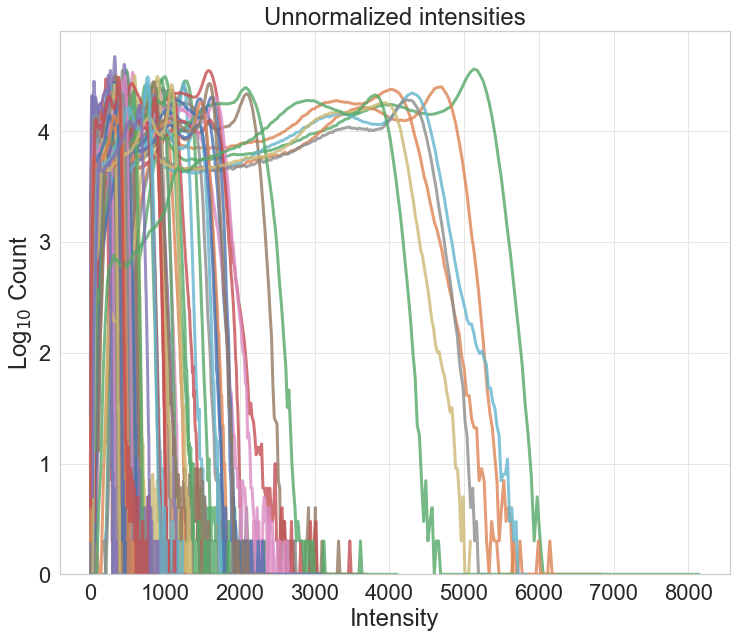

In [1]:
# For visualizing the intensity distribution

from data_utils.preprocessing import plot_intensity_dist

# plot_intensity_dist(imgs_path='unnorm_stripped_imgs', 
#                     img_suffix='stripped.nii', 
#                     mask_suffix='masked.nii', 
#                     cropped=False,
#                     title='Unnormalized intensities')

# plot_intensity_dist(imgs_path='znorm_stripped_imgs', 
#                     img_suffix='znorm.nii', 
#                     mask_suffix='masked.nii', 
#                     cropped=False,
#                     title='Z-score normalized intensities')

# plot_intensity_dist(imgs_path='wsnorm_stripped_imgs', 
#                     img_suffix='wsnorm.nii', 
#                     mask_suffix='masked.nii', 
#                     cropped=False,
#                     title='WS Norm intensities')

# plot_intensity_dist(imgs_path='ws_mm_stripped_imgs', 
#                     img_suffix='wsnorm.nii', 
#                     mask_suffix='masked.nii', 
#                     cropped=False,
#                     title='WS Norm + MinMax-ed intensities')

## Extracting region of interest around the hippocampus

**Please make sure you have removed the 20 subjects that have incorrect orientation or unusual anatomy and corrected the mislabelled left and right hippocampus for the other 4 subjects stated below, before you proceed to the next steps\!** 

Next we crop the images to obtain the region surrounding the hippocampus. This is obtained by going over every image and detecting the maximal 'boundaries' of the hippocampus along the axial, sagittal and coronal views.

While examining the images, I realised that the hippocampus masks files were incorrectly labelled (L should be R, R should be L) for the following four subjects:

* 007_S_1304
* 016_S_4121
* 029_S_4279
* 136_S_0429

Please **ensure that they are corrected by renaming these files**. For example, 'ADNI_007_S_1304_L.nii' should be renamed to 'ADNI_007_S_1304_R.nii' and 'ADNI_007_S_1304_R.nii' should be renamed to 'ADNI_007_S_1304_L.nii'.

In [ ]:
from data_utils.preprocessing import find_max_boundary, get_bounding_boxes

left, right = find_max_boundary('ws_mm_stripped_imgs')
print(left)
print(right)

We then further expand the boundaries to obtain bounding boxes with dimensions that are evenly numbered, so as to avoid dimension shape incompatibility, since our U-Net based models performs downsampling followed by upsampling. Our region of interest is a bounding box/cuboid with dimensions of $40 \times 56 \times 72$.

In [ ]:
# Each input has dimensions 40x56x72
left = [[57, 96+1], [77, 132+1], [37, 108+1]]
right = [[100, 139+1], [81, 136+1], [38, 109+1]]
#get_bounding_boxes(left, right, 'fcmnorm_gm_stripped_imgs', 'fcmnorm.nii', 'fcm_gm_cropped_imgs')
#get_bounding_boxes(left, right, 'wsnorm_stripped_imgs', 'wsnorm.nii', 'ws_cropped_imgs')
#get_bounding_boxes(left, right, 'unnorm_stripped_imgs', 'stripped.nii', 'unnorm_cropped_imgs')
#get_bounding_boxes(left, right, 'znorm_stripped_imgs', 'znorm.nii', 'znorm_cropped_imgs')
get_bounding_boxes(left, right, 'ws_mm_stripped_imgs', 'wsnorm.nii', 'ws_mm_cropped_imgs')

All the cropped and intensity normalized images are in your new folder(s) as specified in the `get_bounding_boxes` function.

We use `plot_intensity_dist` function to visualise the distribution of the intensities for the regions of interest.

In [ ]:
from data_utils.preprocessing import minmax_scale

minmax_scale('wsnorm_stripped_imgs', 'ws_mm1_stripped_imgs', 'wsnorm.nii', False)

In [ ]:
from data_utils.preprocessing import plot_intensity_dist
# plot_intensity_dist(imgs_path='unnorm_cropped_imgs', 
#                     img_suffix='LB.nii',
#                     title='Unnormalized intensities for left brain ROI',
#                     cropped=True)
plot_intensity_dist(imgs_path='znorm_cropped_imgs',
                    img_suffix='LB.nii',
                    title='Z-normalized intensities for left brain ROI',
                    cropped=True)
plot_intensity_dist(imgs_path='ws_cropped_imgs', 
                    img_suffix='LB.nii',
                    title='WS Norm-ed intensities for left brain ROI',
                    cropped=True)
plot_intensity_dist(imgs_path='ws_mm_cropped_imgs', 
                    img_suffix='LB.nii',
                    title='WS + MinMax-ed intensities for left brain ROI',
                    cropped=True)

# plot_intensity_dist(imgs_path='fcm_cropped_imgs', 
#                     img_suffix='RB.nii',
#                     title='FCM Norm-ed intensities for right brain ROI',
#                     cropped=True)
# plot_intensity_dist(imgs_path='ws_cropped_imgs', 
#                     img_suffix='RB.nii',
#                     title='WS Norm-ed intensities for right brain ROI',
#                     cropped=True)

## Splitting the dataset into training, validation and test sets

Our full dataset consists of 115 subjects, each with two regions of the brain (left and right) to perform hippocampus segmentation on. 

In [23]:
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold, train_test_split

valid_subjects = os.listdir('znorm_cropped_imgs')
harp_meta = pd.read_csv('harp_metadata.csv')
harp_meta = harp_meta.loc[harp_meta['Subject'].isin(valid_subjects), 
                          ['Subject', 'Group', 'Age', 'Sex']]


train_meta, test_meta = train_test_split(harp_meta, 
                                         test_size=25, 
                                         random_state=42,
                                         shuffle=True,
                                         stratify=harp_meta['Group'])

train_ids = list(train_meta['Subject'])


In [23]:
# Further split the training for 5-fold cross validation
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for fold_num, train_test_idx in enumerate(skf.split(train_meta['Subject'],
                                                    train_meta['Group'])):
    print("Fold: {0}, Train: {1}, Val: {2}".format(fold_num, 
                                                    train_test_idx[0],
                                                    train_test_idx[1]))
    
    tmp_train_set, tmp_val_set = train_meta.iloc[train_test_idx[0], :], train_meta.iloc[train_test_idx[1], :]
    


Fold: 0, Train: [ 0  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 27 28 29
 31 32 33 34 35 36 37 38 40 44 45 47 48 49 51 52 53 54 55 56 57 59 60 61
 63 64 65 66 68 69 70 71 72 73 75 76 77 79 80 81 82 83 84 85 86 87 88 89], Val: [ 1  2  3 13 25 26 30 39 41 42 43 46 50 58 62 67 74 78]
Fold: 1, Train: [ 0  1  2  3  4  5  6  7  8  9 11 13 15 16 21 22 23 24 25 26 27 28 29 30
 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 49 50 51 52 54 55 56 57
 58 59 60 62 63 65 66 67 68 69 71 72 73 74 76 77 78 79 80 81 83 84 85 87], Val: [10 12 14 17 18 19 20 32 48 53 61 64 70 75 82 86 88 89]
Fold: 2, Train: [ 0  1  2  3  4  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 30 32 33 34 35 36 37 39 40 41 42 43 44 46 47 48 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 72 74 75 78 82 84 85 86 87 88 89], Val: [ 5  8 16 24 28 29 31 38 45 49 71 73 76 77 79 80 81 83]
Fold: 3, Train: [ 0  1  2  3  5  7  8  9 10 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 3

In [1]:
import functools
import logging
import datetime

def deco(func):
    @functools.wraps(func)
    def inner(*args, **kwargs):
        start = datetime.datetime.now()
        func(*args, **kwargs)
        finish = datetime.datetime.now()
        print("Total time taken: {0:.5f} seconds".format((finish-start).total_seconds()))
    
    return inner

@deco
def train_model():
    print("MODEL TRAINING NOW")
    
    
train_model()

MODEL TRAINING NOW
Total time taken: 0.00027 seconds


In [134]:
str.upper("local")

'LOCAL'